In [1]:
import pandas as pd
from pathlib import Path

MATRES_DATA_PATH = Path('../data') / 'MATRES'
AQUAINT_RAW = MATRES_DATA_PATH / 'raw' / 'TBAQ-cleaned' / 'AQUAINT'

aquaint_df = pd.read_csv(MATRES_DATA_PATH / 'aquaint.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])
aquaint_df.eiid1 = 'e' + aquaint_df.eiid1.astype(str)
aquaint_df.eiid2 = 'e' + aquaint_df.eiid2.astype(str)
aquaint_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,NYT20000406.0002,said,made,e1,e2,AFTER
1,NYT20000406.0002,made,raised,e2,e5,AFTER
2,NYT20000406.0002,left,stir,e17,e19,EQUAL
3,NYT20000406.0002,left,demanded,e17,e21,BEFORE
4,NYT20000406.0002,stir,demanded,e19,e21,BEFORE
...,...,...,...,...,...,...
6399,APW19980911.0475,transferred,transported,e28,e31,VAGUE
6400,APW19980911.0475,said,exploded,e29,e30,AFTER
6401,APW19980911.0475,said,transported,e29,e31,AFTER
6402,APW19980911.0475,exploded,transported,e30,e31,BEFORE


In [2]:
from functools import reduce
import networkx as nx

supported_relation = ['AFTER', 'BEFORE']

def create_edges(df):
    edges_df = pd.DataFrame()
    edges_df[['source', 'target']] = df[['docid', 'eiid1', 'eiid2', 'relation']] \
        .apply(lambda row: (f"{row.docid}-{row['eiid2']}" ,f"{row.docid}-{row['eiid1']}")
                if row['relation'] == 'AFTER' else (f"{row.docid}-{row['eiid1']}" , f"{row.docid}-{row['eiid2']}"),
               axis='columns', result_type="expand")
    return edges_df

def create_nodes(df):
    nodes_raw_df = df.apply(lambda row: [dict(docid=row.docid, verb=row.verb1, eiid=f"{row.docid}-{row.eiid1}", eid=row.eiid1),
                                  dict(docid=row.docid, verb=row.verb2, eiid=f"{row.docid}-{row.eiid2}", eid=row.eiid2)], axis='columns').to_list()
    nodes_flatten = reduce(lambda x, y: x+y, nodes_raw_df)
    return pd.DataFrame(nodes_flatten).drop_duplicates(ignore_index=True)

def generate_directed_graph(df, relations=supported_relation):
    df = df.loc[df['relation'].isin(relations)]
    edges = create_edges(df)
    nodes = create_nodes(df)

    # G = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges, create_using=nx.DiGraph)
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.docid)), 'docid')
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.verb)), 'verb')
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.eid)), 'eid')
    return G

def generate_subgraph_by_docid(graph, doc_id):
    sub_graph = []
    for (n, data) in graph.nodes(data=True):
      if data['docid'] == doc_id:
        sub_graph.append(n)
    
    return graph.subgraph(sub_graph).copy()

In [3]:
def draw_directed_graph(graph, title=None, label_name=None):
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = (15,10)

    labels = nx.get_node_attributes(graph, label_name) 
    # pos = nx.kamada_kawai_layout(graph)
    # pos = nx.spring_layout(graph, seed=47)

    for layer, nodes in enumerate(nx.topological_generations(graph)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            graph.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(graph, subset_key="layer")

    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
    nx.draw_networkx_nodes(graph, pos, node_color="tab:blue", **options)
    if label_name is not None:
        nx.draw_networkx_labels(graph, pos, labels=labels, font_size=12, font_color="whitesmoke")
    else:
        nx.draw_networkx_labels(graph, pos, font_size=12, font_color="whitesmoke")
    nx.draw_networkx_edges(
        graph, 
        pos, 
        arrows=True,
        edgelist=graph.edges(), 
        edge_color='tab:blue', 
        alpha=0.5,
        width=3, 
        label="S", 
        arrowstyle='-|>')
    
    # plt.legend(fontsize = 'medium')
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
from itertools import chain, product, starmap
from functools import partial

def create_simple_graph(graph):

    # find connected components
    conn_components = nx.connected_components(graph.to_undirected())

    simple_edges = []
    for nodes in conn_components:
        # create copy of DiGraph
        sub_shallow = graph.subgraph(nodes).copy()

        if len(sub_shallow.edges) <= 2:
            simple_edges.extend([edge for edge in sub_shallow.edges])
            continue

        new_graph = nx.DiGraph()
        new_graph.add_nodes_from(sub_shallow.nodes(data=True))
        new_graph.add_edges_from(sub_shallow.edges)

        # find simple paths
        chaini = chain.from_iterable
        roots = (v for v, d in new_graph.in_degree() if d == 0)
        leaves = (v for v, d in new_graph.out_degree() if d == 0)

        all_paths = partial(nx.all_simple_paths, new_graph)
        all_simple_paths = chaini(starmap(all_paths, product(roots, leaves)))

        # remove redundant paths
        sorted_path = sorted(all_simple_paths, key=lambda x: -len(x))
        max_path = set(sorted_path[0])

        simple_edges.append(sorted_path[0])
        for path in sorted_path[1:]:
            if len(max_path | set(path)) > len(max_path):
                max_path.update(path)
                simple_edges.append(path)

    simple_graph = nx.DiGraph()
    simple_graph.add_nodes_from(graph.nodes(data=True))

    for path in simple_edges:
        nx.add_path(simple_graph, path)

    return simple_graph, simple_edges

In [5]:
from bs4 import BeautifulSoup

class Doc:
    def __init__(self, path: Path):
        self.path = path
        self.doc = self.parse()
        self.docid = self.doc.find('docid').get_text()
        self.mapping = self.get_mapping()
        self.text = self.get_text()
        self.relations = self.get_relations()
    
    def parse(self):
        with self.path.open('r') as f:
            data = f.read()
        return BeautifulSoup(data)
    
    def get_mapping(self):
        text = self.doc.find(name="text")
        return {d.get("eid"): d.get_text().lower() for d in text.find_all('event') if d.get("eid") is not None}
    
    def get_text(self):
        text = self.doc.find(name="text")
        [d.replace_with(f'{d.get("eid")}:{d.get_text().upper()}')  for d in text.find_all('event')]
        [d.replace_with(d.get_text())  for d in text.find_all('timex3')]
        return text.get_text().strip()

    def get_relations(self):
        relations = ((d.get('eventinstanceid'), d.get('relatedtoeventinstance'), d.get('reltype')) for d in self.doc.find_all('tlink') if d.get('reltype') in set(['IBEFORE', 'BEFORE', 'AFTER', 'IAFTER']))
        return list(filter(lambda d: d[0] is not None and d[1] is not None ,relations))
        

In [6]:
def prepare_df_from_response(response, doc_obj):
    data = []
    for e1e2 in response.splitlines():
        if 'before' in e1e2:
            relation = 'BEFORE'
            e1, e2 = e1e2.split(' before ')
        else:
            relation = 'AFTER'
            e1, e2 = e1e2.split(' after ')
        
        verb1 = doc_obj.mapping[e1]
        verb2 = doc_obj.mapping[e2]
        
        data.append({
            'docid': doc_obj.docid,
            'verb1': verb1,
            'verb2': verb2,
            'eiid1': e1,
            'eiid2': e2,
            'relation': relation
        })
    return pd.DataFrame(data)

In [8]:
def create_prompt(_input):
    return f"""
Use the uppercase letter with the prefix e[numeric] to describe the timeline graph with temporal relations between them use BEFORE and AFTER. specify only the code name aka e[numeric]. Verify yourself and answer only from the provided text ..
For example: e1 before e2
The text-
{_input}
    """

In [45]:
with open("/Users/adiel/git/MATRES/data/raw/TBAQ-cleaned/AQUAINT/APW19980807.0261.tml", 'r') as f:
    data = f.read()
 
Bs_data = BeautifulSoup(data)

/Users/adiel/git/MATRES/venv/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [75]:
Bs_data.find('docid').get_text()

'APW19980807.0261'

In [53]:
text = Bs_data.find(name="text")
text

<text>

NAIROBI, Kenya (AP) _

Suspected bombs <event class="OCCURRENCE" eid="e1">exploded</event> outside the U.S. embassies in the Kenyan and Tanzanian capitals <timex3 functionindocument="NONE" temporalfunction="false" tid="t1" type="DATE" value="1998-08-07">Friday</timex3>, <event class="OCCURRENCE" eid="e2">killing</event> dozens of people, witnesses <event class="REPORTING" eid="e3">said</event>.

The American ambassador to Kenya was among hundreds <event class="OCCURRENCE" eid="e12">injured</event>, a local TV <event class="REPORTING" eid="e4">said</event>.

``It was definitely a bomb,'' <event class="REPORTING" eid="e5">said</event> a U.S. Embassy official in Nairobi, who <event class="OCCURRENCE" eid="e6">refused</event> to <event class="OCCURRENCE" eid="e7">identify</event> himself. ``You can <event class="PERCEPTION" eid="e8">see</event> a huge crater behind the building, and a bomb <event class="OCCURRENCE" eid="e9">went</event> off at the embassy in Tanzania at the same ti

In [56]:
[d.replace_with(f'{d.get("eid")}:{d.get_text().upper()}')  for d in text.find_all('event')]

[<event class="OCCURRENCE" eid="e1">exploded</event>,
 <event class="OCCURRENCE" eid="e2">killing</event>,
 <event class="REPORTING" eid="e3">said</event>,
 <event class="OCCURRENCE" eid="e12">injured</event>,
 <event class="REPORTING" eid="e4">said</event>,
 <event class="REPORTING" eid="e5">said</event>,
 <event class="OCCURRENCE" eid="e6">refused</event>,
 <event class="OCCURRENCE" eid="e7">identify</event>,
 <event class="PERCEPTION" eid="e8">see</event>,
 <event class="OCCURRENCE" eid="e9">went</event>,
 <event class="REPORTING" eid="e10">said</event>]

In [58]:
[d.replace_with(d.get_text())  for d in text.find_all('timex3')]

[<timex3 functionindocument="NONE" temporalfunction="false" tid="t1" type="DATE" value="1998-08-07">Friday</timex3>]

In [61]:
text.get_text().strip()

"NAIROBI, Kenya (AP) _\n\nSuspected bombs e1:EXPLODED outside the U.S. embassies in the Kenyan and Tanzanian capitals Friday, e2:KILLING dozens of people, witnesses e3:SAID.\n\nThe American ambassador to Kenya was among hundreds e12:INJURED, a local TV e4:SAID.\n\n``It was definitely a bomb,'' e5:SAID a U.S. Embassy official in Nairobi, who e6:REFUSED to e7:IDENTIFY himself. ``You can e8:SEE a huge crater behind the building, and a bomb e9:WENT off at the embassy in Tanzania at the same time,'' he e10:SAID."

In [63]:
aquaint_df[aquaint_df.docid == 'APW19980807.0261']

,docid,verb1,verb2,eiid1,eiid2,relation
5638,APW19980807.0261,exploded,killing,1,2,BEFORE
5639,APW19980807.0261,exploded,said,1,3,BEFORE
5640,APW19980807.0261,killing,said,2,3,BEFORE
5641,APW19980807.0261,exploded,injured,1,12,BEFORE
5642,APW19980807.0261,exploded,said,1,4,BEFORE
5643,APW19980807.0261,killing,injured,2,12,BEFORE
5644,APW19980807.0261,killing,said,2,4,BEFORE
5645,APW19980807.0261,said,injured,3,12,AFTER
5646,APW19980807.0261,said,said,3,4,BEFORE
5647,APW19980807.0261,injured,said,12,4,BEFORE


chatGPT Answer
Prompt:
```
Use the uppercase letter with the prefix e[numeric] to describe the timeline graph with temporal relations between them use BEFORE and AFTER. specify only the code name aka e[numeric]. Verify yourself.
For example: e1 before e2
The text-
"NAIROBI, Kenya (AP) _\n\nSuspected bombs e1:EXPLODED outside the U.S. embassies in the Kenyan and Tanzanian capitals Friday, e2:KILLING dozens of people, witnesses e3:SAID.\n\nThe American ambassador to Kenya was among hundreds e12:INJURED, a local TV e4:SAID.\n\n``It was definitely a bomb,'' e5:SAID a U.S. Embassy official in Nairobi, who e6:REFUSED to e7:IDENTIFY himself. ``You can e8:SEE a huge crater behind the building, and a bomb e9:WENT off at the embassy in Tanzania at the same time,'' he e10:SAID."
```
Answer
```
e1 before e2
e2 before e3
e12 before e4
e5 before e6
e7 before e8
e8 before e9
e9 before e10
```

In [70]:
[(d.get('eventinstanceid'), d.get('relatedtoeventinstance'), d.get('reltype')) for d in Bs_data.find_all('tlink') if d.get('reltype') in set(['IBEFORE', 'BEFORE', 'AFTER'])]

[('ei1', 'ei2', 'IBEFORE'),
 ('ei2', 'ei3', 'BEFORE'),
 ('ei3', 'ei12', 'AFTER'),
 ('ei12', 'ei4', 'BEFORE'),
 ('ei1', 'ei5', 'BEFORE'),
 ('ei5', 'ei6', 'BEFORE'),
 ('ei9', 'ei10', 'BEFORE'),
 ('ei1', 'ei8', 'BEFORE'),
 ('ei12', 'ei1', 'AFTER'),
 ('ei3', None, 'BEFORE'),
 ('ei4', None, 'BEFORE'),
 ('ei5', None, 'BEFORE'),
 ('ei6', None, 'BEFORE'),
 ('ei10', None, 'BEFORE')]

In [17]:
APW19980807_0261 = Doc(AQUAINT_RAW / 'APW19980807.0261.tml')

/Users/adiel/git/MATRES/venv/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [51]:
print(create_prompt(APW19980807_0261.get_text()))


Use the uppercase letter with the prefix e[numeric] to describe the timeline graph with temporal relations between them use BEFORE and AFTER. specify only the code name aka e[numeric]. Verify yourself.
For example: e1 before e2
The text-
NAIROBI, Kenya (AP) _

Suspected bombs e1:EXPLODED outside the U.S. embassies in the Kenyan and Tanzanian capitals Friday, e2:KILLING dozens of people, witnesses e3:SAID.

The American ambassador to Kenya was among hundreds e12:INJURED, a local TV e4:SAID.

``It was definitely a bomb,'' e5:SAID a U.S. Embassy official in Nairobi, who e6:REFUSED to e7:IDENTIFY himself. ``You can e8:SEE a huge crater behind the building, and a bomb e9:WENT off at the embassy in Tanzania at the same time,'' he e10:SAID.
    


In [153]:
aquaint_df[aquaint_df.docid == 'APW19980807.0261'].columns

Index(['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'], dtype='object')

In [18]:
response = """e1 before e2
e2 before e3
e12 before e4
e5 before e6
e7 before e8
e8 before e9
e9 before e10"""

data = []
for e1e2 in response.splitlines():
    if 'before' in e1e2:
        relation = 'BEFORE'
        e1, e2 = e1e2.split(' before ')
    else:
        relation = 'AFTER'
        e1, e2 = e1e2.split(' after ')
    
    verb1 = APW19980807_0261.mapping[e1]
    verb2 = APW19980807_0261.mapping[e2]
    docid = 'APW19980807.0261'
    
    data.append({
        'docid': docid,
        'verb1': verb1,
        'verb2': verb2,
        'eiid1': e1,
        'eiid2': e2,
        'relation': relation
    })
llm_answer_df = pd.DataFrame(data)
llm_answer_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,APW19980807.0261,exploded,killing,e1,e2,BEFORE
1,APW19980807.0261,killing,said,e2,e3,BEFORE
2,APW19980807.0261,injured,said,e12,e4,BEFORE
3,APW19980807.0261,said,refused,e5,e6,BEFORE
4,APW19980807.0261,identify,see,e7,e8,BEFORE
5,APW19980807.0261,see,went,e8,e9,BEFORE
6,APW19980807.0261,went,said,e9,e10,BEFORE


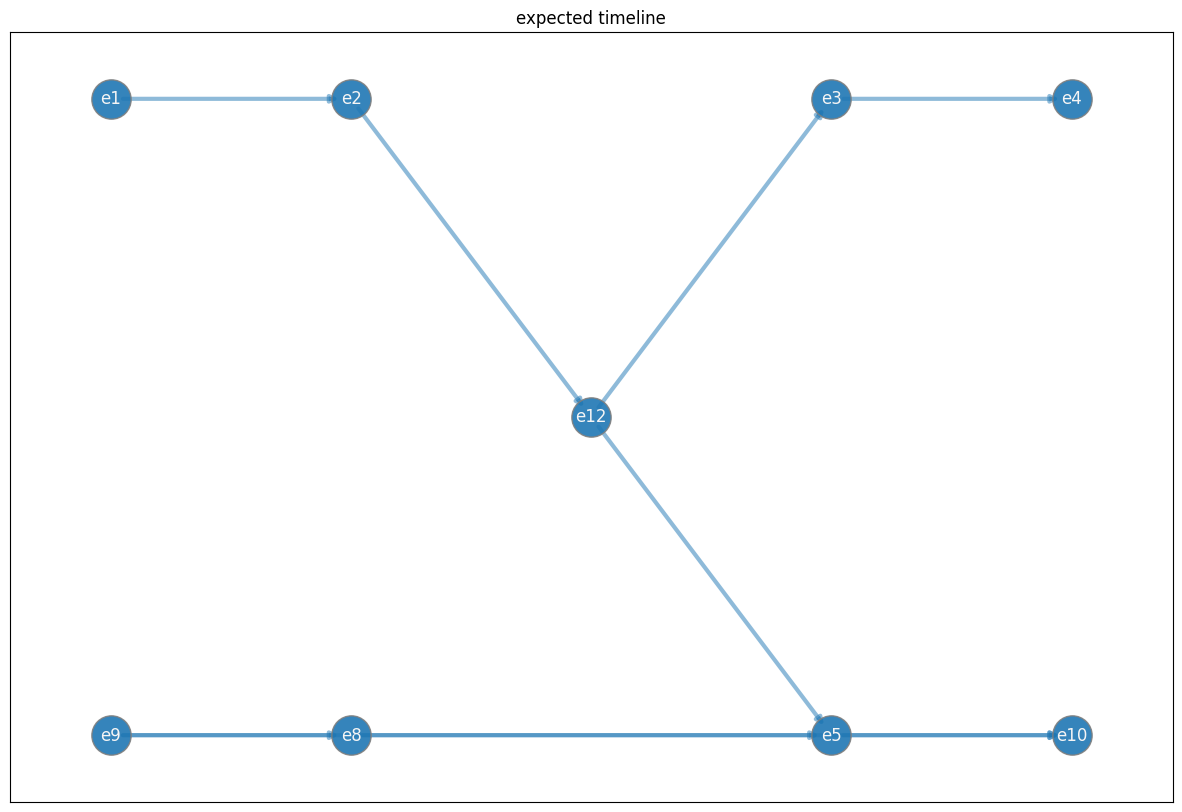

In [46]:
APW19980807_0261_graph = generate_directed_graph(df=aquaint_df[aquaint_df.docid == 'APW19980807.0261'])
APW19980807_0261_graph_simple, _ = create_simple_graph(graph=APW19980807_0261_graph)
draw_directed_graph(APW19980807_0261_graph_simple, title='expected timeline', label_name='eid')

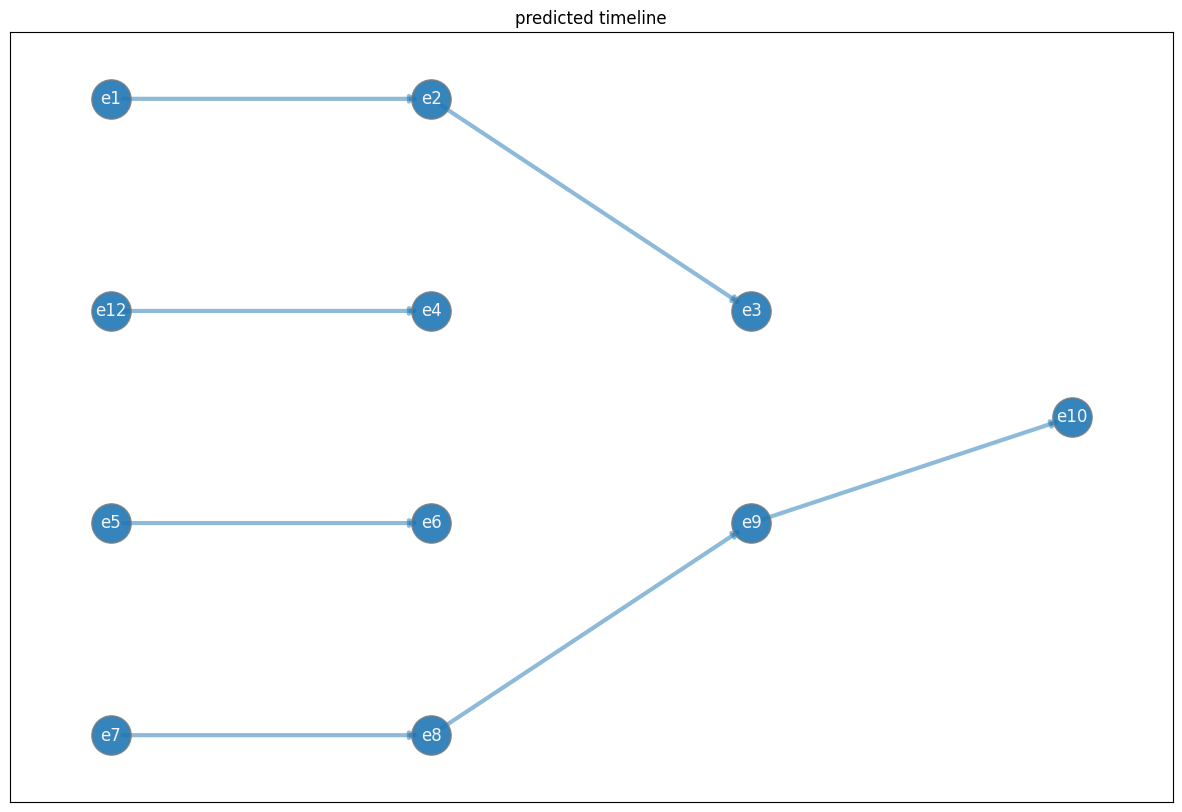

In [47]:
llm_answer_df_graph = generate_directed_graph(df=llm_answer_df)
llm_answer_df_graph_simple, _ = create_simple_graph(graph=llm_answer_df_graph)
draw_directed_graph(llm_answer_df_graph_simple, title='predicted timeline', label_name='eid')

In [9]:
APW19980808_0022 = Doc(AQUAINT_RAW / 'APW19980808.0022.tml')

/Users/adiel/git/MATRES/venv/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [80]:
APW19980808_0022.get_text()

"NAIROBI, Kenya (AP) _\n\nTerrorist e24:BOMBINGS at U.S. embassies in Kenya and Tanzania e1:BLEW apart buildings and buses, e2:TRAPPING people under slabs of concrete and twisted steel that rescuers e3:CLEARED with cranes, blow torches and bare hands.\n\nAt least 82 were e4:KILLED and more than 1,700 e36:INJURED, officials e5:SAID as dawn e6:BROKE Saturday. Dozens of people were still e7:MISSING, however, and the death toll was e8:EXPECTED to e9:RISE, they e10:SAID.\n\nThe suspected car e29:BOMBINGS occurred 700 kilometers (450 miles) from each other but just minutes apart on Friday, e12:TURNING busy streets in two African capitals into bloody piles of concrete and knots of steel.\n\n``This e13:APPEARS to have been a very well-coordinated, very well-planned e30:ATTACK _ clearly not the work of amateurs,'' U.S. National Security Council spokesman P.J. Crowley e16:SAID in Washington. No one has e17:CLAIMED responsibility.\n\nThe e33:BLAST in Nairobi occurred at about 10:35 a.m. (0735 GMT

In [86]:
print(create_prompt(APW19980808_0022.get_text()))


Use the uppercase letter with the prefix e[numeric] to describe the timeline graph with temporal relations between them use BEFORE and AFTER. specify only the code name aka e[numeric]. Verify yourself.
For example: e1 before e2
The text-
NAIROBI, Kenya (AP) _

Terrorist e24:BOMBINGS at U.S. embassies in Kenya and Tanzania e1:BLEW apart buildings and buses, e2:TRAPPING people under slabs of concrete and twisted steel that rescuers e3:CLEARED with cranes, blow torches and bare hands.

At least 82 were e4:KILLED and more than 1,700 e36:INJURED, officials e5:SAID as dawn e6:BROKE Saturday. Dozens of people were still e7:MISSING, however, and the death toll was e8:EXPECTED to e9:RISE, they e10:SAID.

The suspected car e29:BOMBINGS occurred 700 kilometers (450 miles) from each other but just minutes apart on Friday, e12:TURNING busy streets in two African capitals into bloody piles of concrete and knots of steel.

``This e13:APPEARS to have been a very well-coordinated, very well-planned e3

In [93]:
APW19980808_0022.relations

[('ei24', 'ei2', 'BEFORE'),
 ('ei12', 'ei29', 'AFTER'),
 ('ei13', 'ei30', 'AFTER'),
 ('ei13', 'ei16', 'BEFORE'),
 ('ei33', 'ei19', 'BEFORE'),
 ('ei33', 'ei21', 'BEFORE'),
 ('ei33', 'ei22', 'BEFORE'),
 ('ei22', 'ei23', 'BEFORE'),
 ('ei24', 'ei4', 'IBEFORE'),
 ('ei36', 'ei6', 'BEFORE'),
 ('ei24', 'ei7', 'BEFORE'),
 ('ei8', 'ei10', 'BEFORE')]

In [89]:
aquaint_df[aquaint_df.docid == 'APW19980808.0022']

,docid,verb1,verb2,eiid1,eiid2,relation
5869,APW19980808.0022,blew,trapping,1,2,BEFORE
5870,APW19980808.0022,blew,cleared,1,3,BEFORE
5871,APW19980808.0022,trapping,cleared,2,3,BEFORE
5872,APW19980808.0022,blew,killed,1,4,BEFORE
5873,APW19980808.0022,blew,injured,1,36,BEFORE
5874,APW19980808.0022,blew,said,1,5,BEFORE
5875,APW19980808.0022,blew,broke,1,6,BEFORE
5876,APW19980808.0022,trapping,killed,2,4,BEFORE
5877,APW19980808.0022,trapping,injured,2,36,BEFORE
5878,APW19980808.0022,trapping,said,2,5,BEFORE


chatGPT 
Answer
```
e24 before e1
e1 before e2
e2 before e3
e3 before e4
e4 before e36
e5 before e6
e6 before e7
e8 before e9
e9 before e10
e29 before e12
```

In [12]:
response = """e24 before e1
e1 before e2
e2 before e3
e3 before e4
e4 before e36
e5 before e6
e6 before e7
e8 before e9
e9 before e10
e29 before e12"""

data = []
for e1e2 in response.splitlines():
    if 'before' in e1e2:
        relation = 'BEFORE'
        e1, e2 = e1e2.split(' before ')
    else:
        relation = 'AFTER'
        e1, e2 = e1e2.split(' after ')
    
    verb1 = APW19980808_0022.mapping[e1]
    verb2 = APW19980808_0022.mapping[e2]
    docid = 'APW19980808.0022'
    
    data.append({
        'docid': docid,
        'verb1': verb1,
        'verb2': verb2,
        'eiid1': e1,
        'eiid2': e2,
        'relation': relation
    })
llm_answer_df = pd.DataFrame(data)
llm_answer_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,APW19980808.0022,bombings,blew,e24,e1,BEFORE
1,APW19980808.0022,blew,trapping,e1,e2,BEFORE
2,APW19980808.0022,trapping,cleared,e2,e3,BEFORE
3,APW19980808.0022,cleared,killed,e3,e4,BEFORE
4,APW19980808.0022,killed,injured,e4,e36,BEFORE
5,APW19980808.0022,said,broke,e5,e6,BEFORE
6,APW19980808.0022,broke,missing,e6,e7,BEFORE
7,APW19980808.0022,expected,rise,e8,e9,BEFORE
8,APW19980808.0022,rise,said,e9,e10,BEFORE
9,APW19980808.0022,bombings,turning,e29,e12,BEFORE


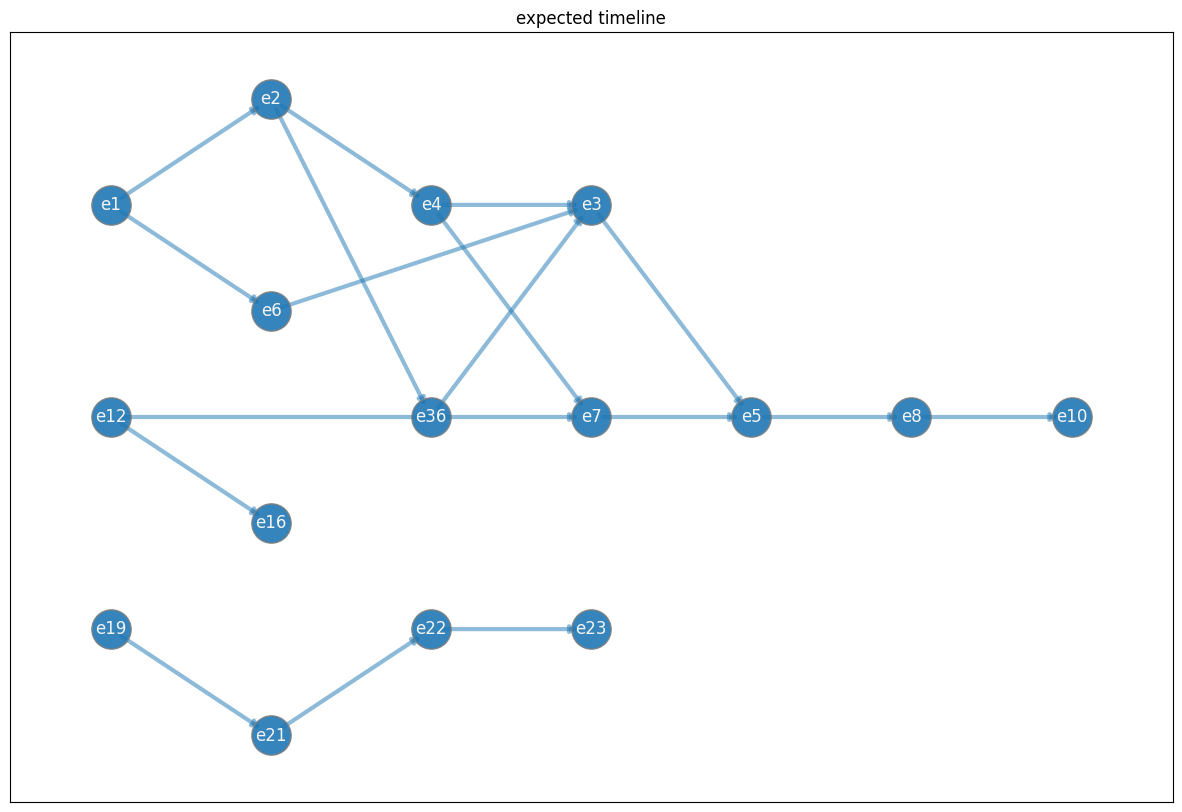

In [48]:
APW19980808_0022_graph = generate_directed_graph(df=aquaint_df[aquaint_df.docid == 'APW19980808.0022'])
APW19980808_0022_graph_simple, _ = create_simple_graph(graph=APW19980808_0022_graph)
draw_directed_graph(APW19980808_0022_graph_simple, title='expected timeline', label_name='eid')

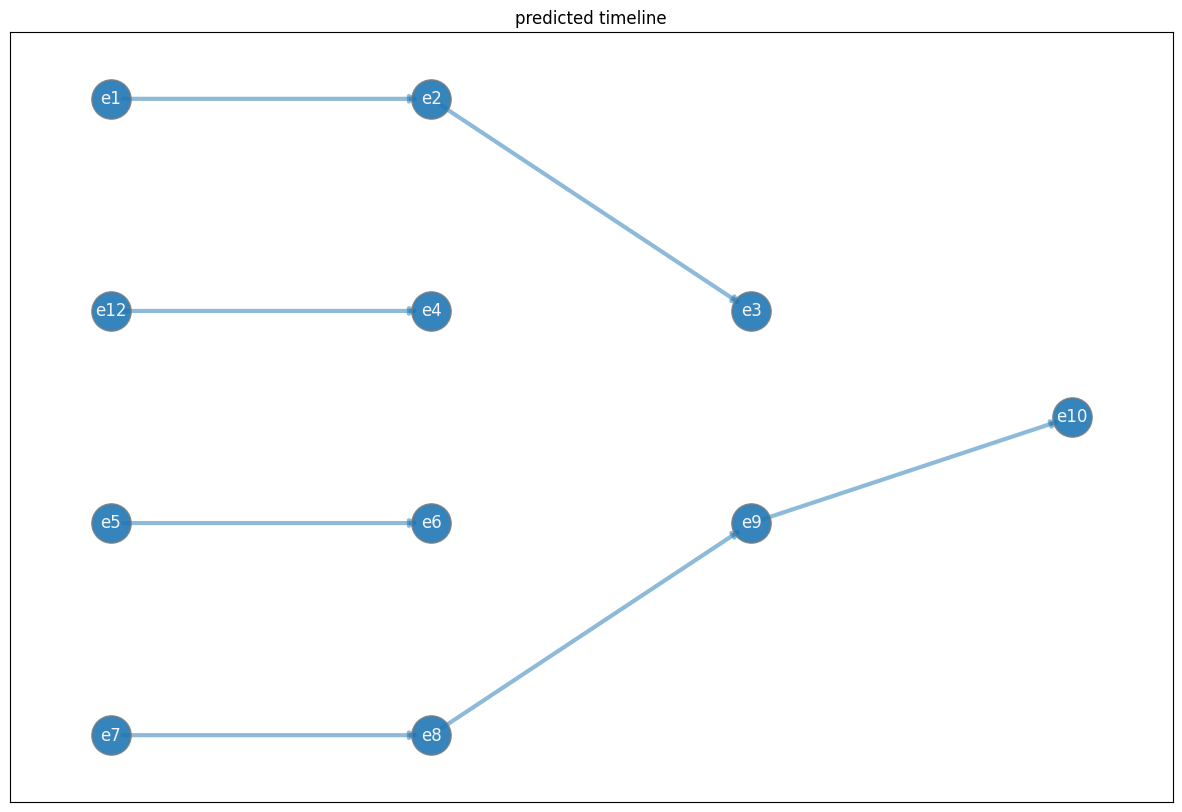

In [49]:
llm_answer_df_graph = generate_directed_graph(df=llm_answer_df)
llm_answer_df_graph_simple, _ = create_simple_graph(graph=llm_answer_df_graph)
draw_directed_graph(llm_answer_df_graph_simple, title='predicted timeline', label_name='eid')

In [10]:
NYT19980907_0112 = Doc(AQUAINT_RAW / 'NYT19980907.0112.tml')

/Users/adiel/git/MATRES/venv/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [21]:
print(create_prompt(NYT19980907_0112.get_text()))


Use the uppercase letter with the prefix e[numeric] to describe the timeline graph with temporal relations between them use BEFORE and AFTER. specify only the code name aka e[numeric]. Verify yourself.
For example: e1 before e2
The text-
WASHINGTON _

The e83:BOMBINGS at the American Embassies in Kenya and Tanzania have e1:FRIGHTENED away travelers from East Africa just as Kenya was hoping for an end to a years-old slump in foreign tourism, and as Tanzania was finally e3:BEGINNING to e137:REAP the benefits from a major investment in the travel industry.

Tour operators who specialize in travel in Kenya and Tanzania, which boast some of Africa's best game parks and sunniest beaches, e6:SAY there have been no mass e91:CANCELLATIONS as a result of the Aug. 7 Embassy e92:BOMBINGS in Nairobi, the Kenyan capital, and Dar es Salaam, Tanzania, which e7:LEFT more than 250 people dead.

But they e8:REPORT a number of worried e138:CALLS from prospective travelers, many of them alarmed by the pos

In [11]:
response = """e83 before e1
e1 before e3
e6 before e91
e92 before e7
e7 before e8
e8 before e138
e15 before e16
e16 before e17
e19 before e20
e20 before e21
e21 before e97
e22 before e97
e24 before e26
e26 before e27
e28 before e30
e30 before e31
e31 before e32
e32 before e33
e33 before e34
e34 before e35
e35 before e36
e36 before e37
e40 before e41
e44 before e45
e45 before e46
e46 before e47
e47 before e49
e49 before e50
e50 before e51
e51 before e55
e55 before e57
e57 before e59
e59 before e61
e61 before e63
e63 before e64
e64 before e65
e65 before e66
e66 before e67
e67 before e68
e68 before e69
e69 before e70
e70 before e72
e72 before e73
e73 before e75
e75 before e76
e76 before e78
e78 before e79
"""
llm_answer_df = prepare_df_from_response(response, NYT19980907_0112)
llm_answer_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,NYT19980907.0112,bombings,frightened,e83,e1,BEFORE
1,NYT19980907.0112,frightened,beginning,e1,e3,BEFORE
2,NYT19980907.0112,say,cancellations,e6,e91,BEFORE
3,NYT19980907.0112,bombings,left,e92,e7,BEFORE
4,NYT19980907.0112,left,report,e7,e8,BEFORE
5,NYT19980907.0112,report,calls,e8,e138,BEFORE
6,NYT19980907.0112,said,want,e15,e16,BEFORE
7,NYT19980907.0112,want,see,e16,e17,BEFORE
8,NYT19980907.0112,targeted,lifted,e19,e20,BEFORE
9,NYT19980907.0112,lifted,issued,e20,e21,BEFORE


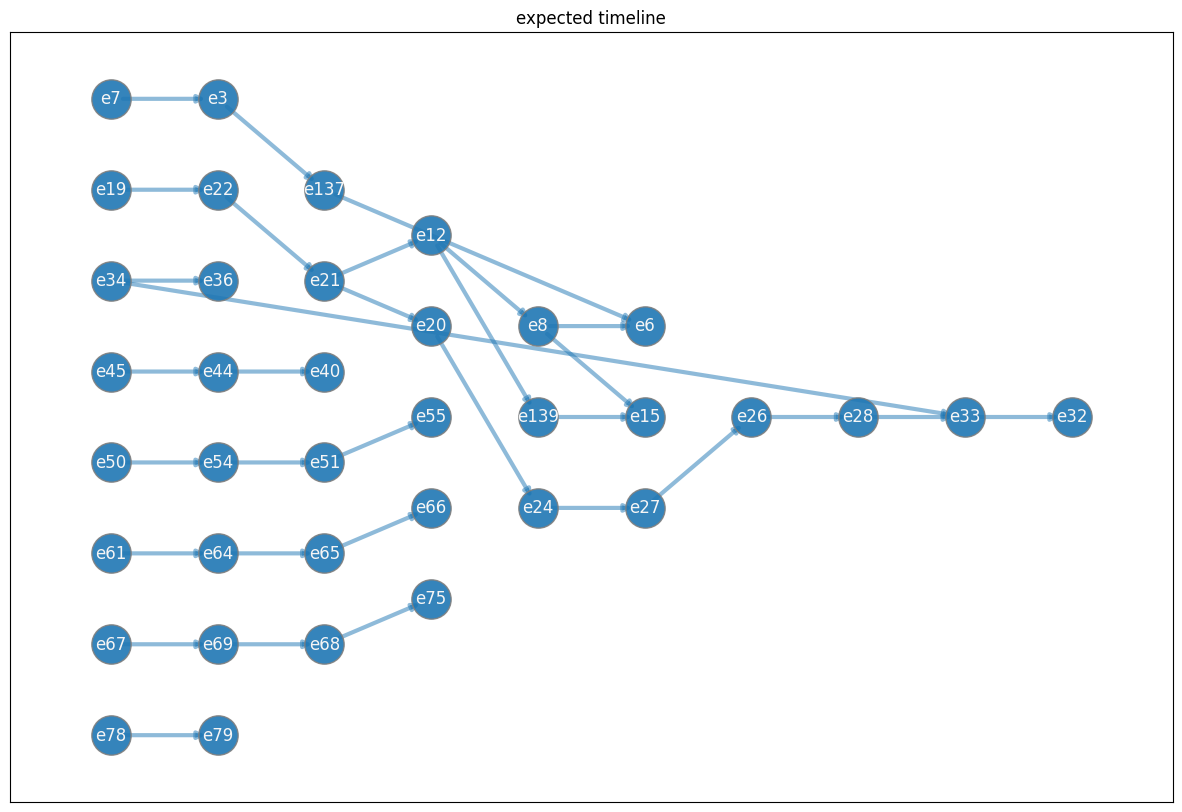

In [12]:
NYT19980907_0112_graph = generate_directed_graph(df=aquaint_df[aquaint_df.docid == 'NYT19980907.0112'])
NYT19980907_0112_graph_simple, _ = create_simple_graph(graph=NYT19980907_0112_graph)
draw_directed_graph(NYT19980907_0112_graph_simple, title='expected timeline', label_name='eid')

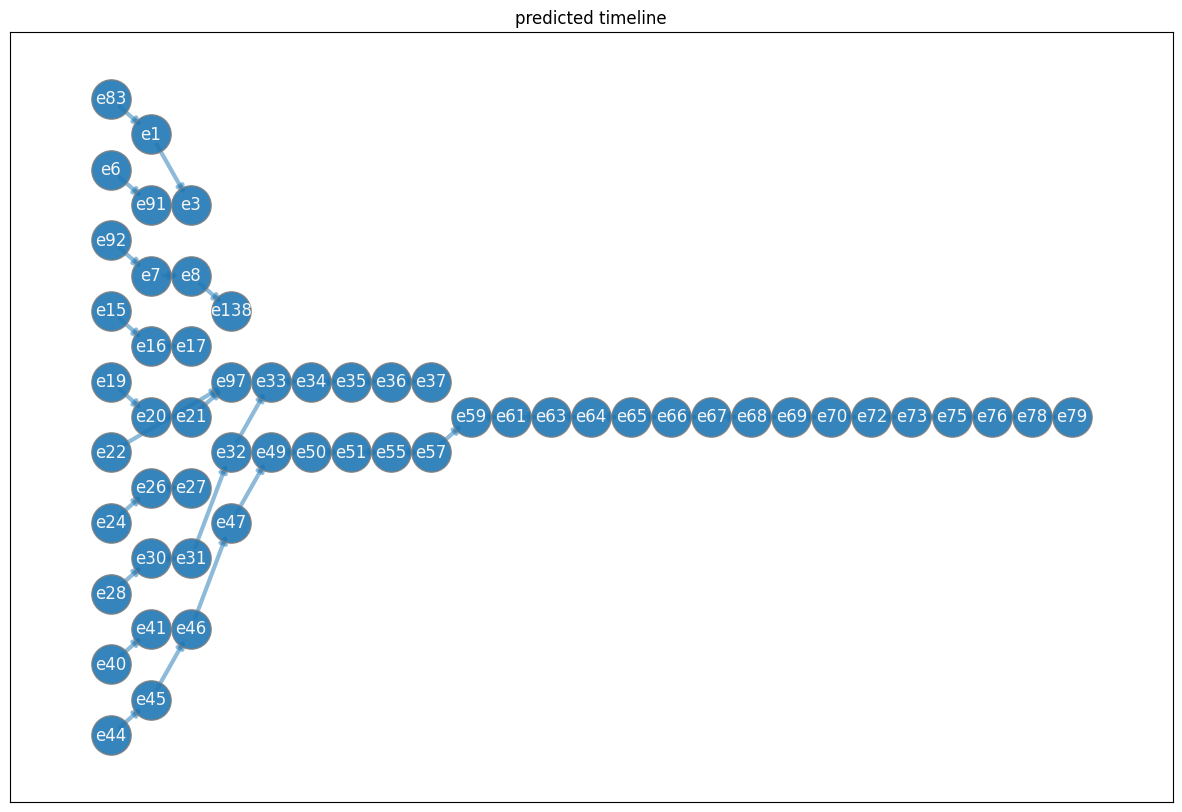

In [13]:
llm_answer_df_graph = generate_directed_graph(df=llm_answer_df)
llm_answer_df_graph_simple, _ = create_simple_graph(graph=llm_answer_df_graph)
draw_directed_graph(llm_answer_df_graph_simple, title='predicted timeline', label_name='eid')

In [23]:
NYT19980907_0112_events = aquaint_df[aquaint_df.docid == 'NYT19980907.0112'].copy()
NYT19980907_0112_events = NYT19980907_0112_events.apply(lambda row: (row.verb2, row.verb1, row.eiid2, row.eiid1, 'BEFORE') if row.relation == 'AFTER' else (row.verb1, row.verb2, row.eiid1, row.eiid2, row.relation), axis='columns', result_type="expand")
NYT19980907_0112_events

,0,1,2,3,4
1132,beginning,reap,e3,e137,BEFORE
1133,beginning,say,e3,e6,BEFORE
1134,left,beginning,e7,e3,BEFORE
1135,reap,say,e137,e6,BEFORE
1136,left,reap,e7,e137,BEFORE
...,...,...,...,...,...
1204,received,said,e69,e68,BEFORE
1205,sending,said,e67,e75,BEFORE
1206,said,said,e68,e75,BEFORE
1207,received,said,e69,e75,BEFORE


In [24]:
XIE19980808_0031 = Doc(AQUAINT_RAW / 'XIE19980808.0031.tml')

/Users/adiel/git/MATRES/venv/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [25]:
print(create_prompt(XIE19980808_0031.get_text()))


Use the uppercase letter with the prefix e[numeric] to describe the timeline graph with temporal relations between them use BEFORE and AFTER. specify only the code name aka e[numeric]. Verify yourself and answer only from the provided text ..
For example: e1 before e2
The text-
JOHANNESBURG, August 7 (Xinhua) --

South Africa e27:DEPLORED Friday the bomb e16:BLASTS which e1:KILLED scores of people and e28:INJURED more than 1,000 others outside embassies of the United States in Kenya and Tanzania earlier in the day.

A statement by the Foreign Affairs Department e2:DESCRIBED the e18:ATTACKS as senseless.

"The South African government deplores these senseless e19:ACTS against the American embassies in Nairobi and Dar es Salaam and would like to e3:EXPRESS its condolences to the victims of the e20:EXPLOSIONS," the statement e4:SAID.

Reports reaching here e6:SAID a massive e22:BLAST e7:DAMAGED the U.S. embassy in Nairobi, e8:KILLING 40 people while e9:WOUNDING at least 1,000 people.

Ke

In [26]:
response = """e27 before e16
e16 before e1
e1 before e28
e2 before e18
e18 before e19
e19 before e3
e3 before e20
e20 before e4
e6 before e22
e22 before e7
e7 before e8
e8 before e9
e9 before e29
e23 before e29
e10 before e24
e24 before e11
e11 before e25
e13 before e14
e14 before e26
e26 before e15
"""
llm_answer_df = prepare_df_from_response(response, XIE19980808_0031)
llm_answer_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,XIE19980808.0031,deplored,blasts,e27,e16,BEFORE
1,XIE19980808.0031,blasts,killed,e16,e1,BEFORE
2,XIE19980808.0031,killed,injured,e1,e28,BEFORE
3,XIE19980808.0031,described,attacks,e2,e18,BEFORE
4,XIE19980808.0031,attacks,acts,e18,e19,BEFORE
5,XIE19980808.0031,acts,express,e19,e3,BEFORE
6,XIE19980808.0031,express,explosions,e3,e20,BEFORE
7,XIE19980808.0031,explosions,said,e20,e4,BEFORE
8,XIE19980808.0031,said,blast,e6,e22,BEFORE
9,XIE19980808.0031,blast,damaged,e22,e7,BEFORE


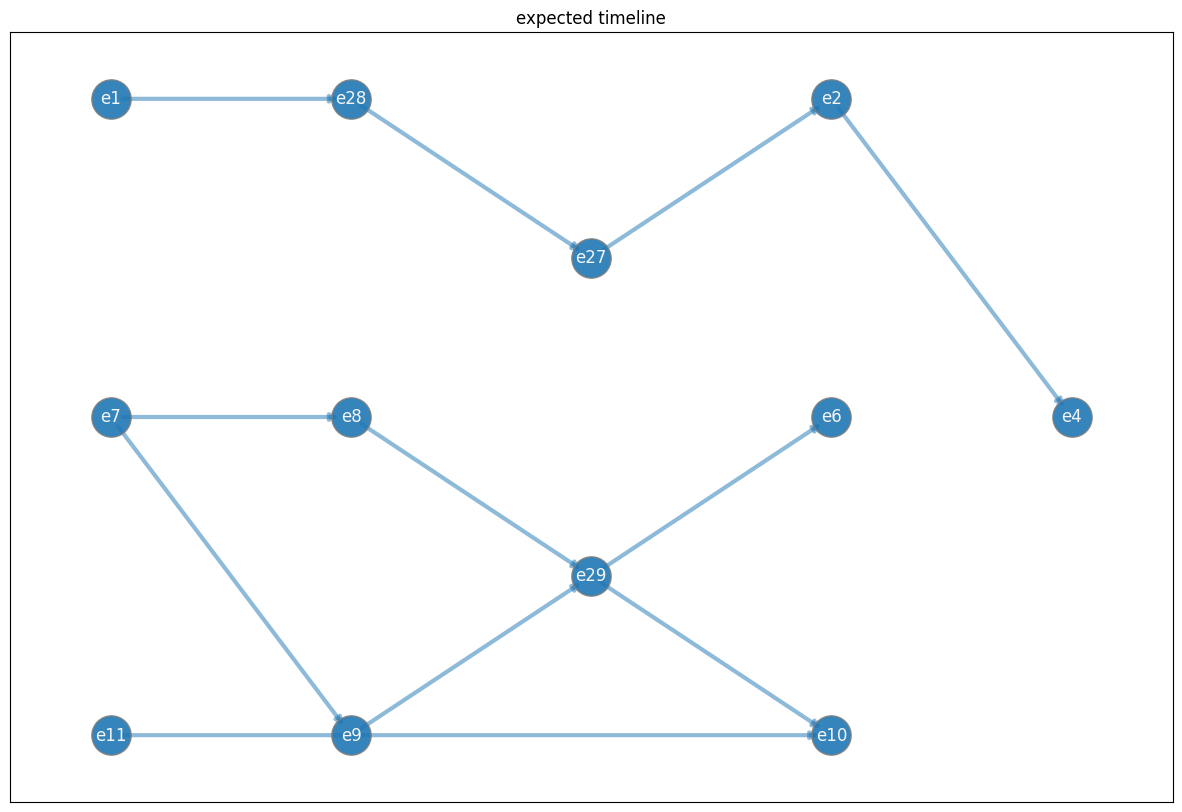

In [28]:
XIE19980808_0031_graph = generate_directed_graph(df=aquaint_df[aquaint_df.docid == 'XIE19980808.0031'])
XIE19980808_0031_graph_simple, _ = create_simple_graph(graph=XIE19980808_0031_graph)
draw_directed_graph(XIE19980808_0031_graph_simple, title='expected timeline', label_name='eid')

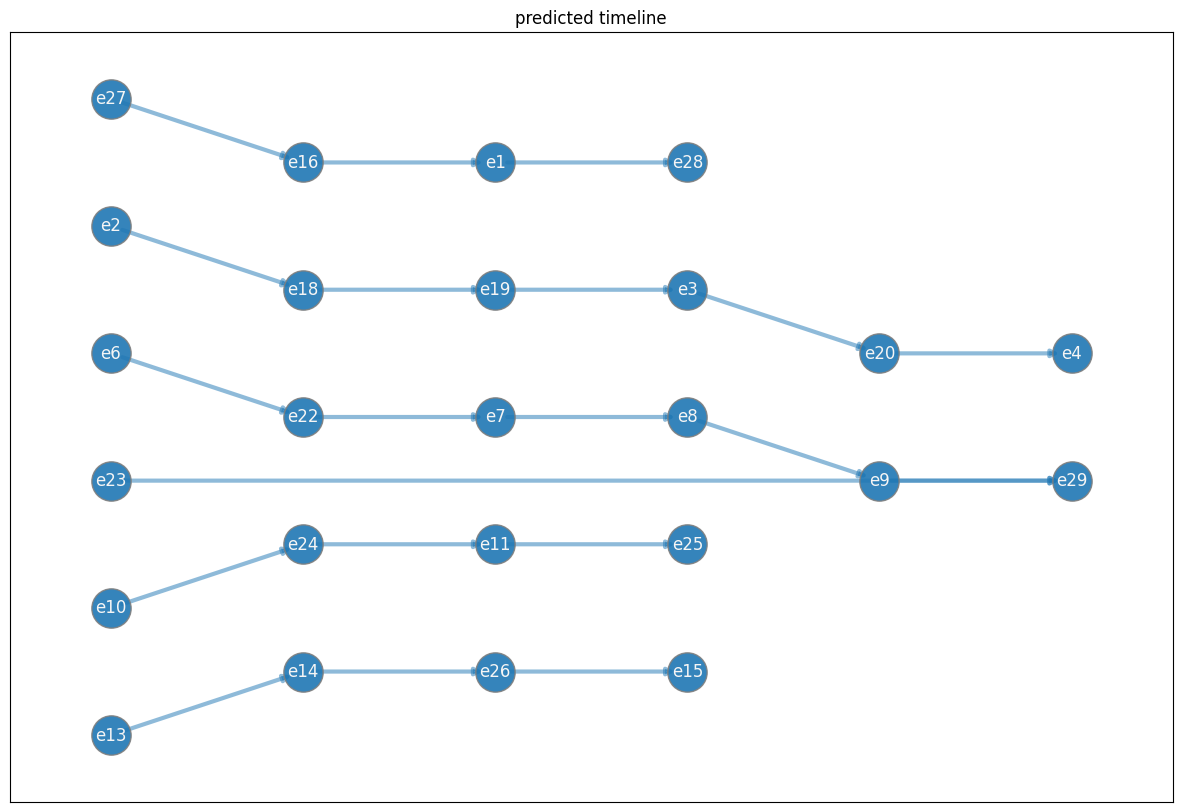

In [29]:
llm_answer_df_graph = generate_directed_graph(df=llm_answer_df)
llm_answer_df_graph_simple, _ = create_simple_graph(graph=llm_answer_df_graph)
draw_directed_graph(llm_answer_df_graph_simple, title='predicted timeline', label_name='eid')